In [38]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

In [20]:
df = pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [21]:
# Сделаем маппинг бинарных колонок 
# и закодируем dummy-кодированием штат (для простоты, лучше не делать так для деревянных моделей)
d = {'Yes' : 1, 'No' : 0}
df['International plan'] = df['International plan'].map(d)
df['Voice mail plan'] = df['Voice mail plan'].map(d)
df['Churn'] = df['Churn'].astype('int64')

In [22]:
le = LabelEncoder()
df['State'] = le.fit_transform(df['State'])

In [23]:
ohe = OneHotEncoder(sparse=False)
encoded_state = ohe.fit_transform(df['State'].values.reshape(-1, 1))
tmp = pd.DataFrame(encoded_state,  
                   columns=['state ' + str(i) for i in range(encoded_state.shape[1])])
df = pd.concat([df, tmp], axis=1)

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [24]:
df['Churn'] = df['Churn'].astype('int64')

In [25]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [26]:
# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  
                                                    test_size=0.33, random_state=42)

In [29]:
# Обучаем ставшую родной логистическую регрессию
lr = LogisticRegression(solver='lbfgs', random_state=42)
lr.fit(X_train, y_train)

/home/zark/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Confusion matrix, without normalization
[[925  16]
 [146  13]]


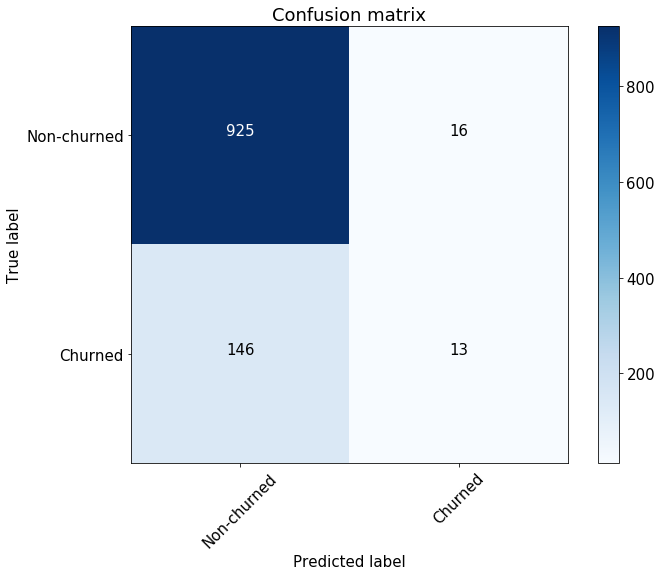

In [36]:
# Воспользуемся функцией построения матрицы ошибок из документации sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

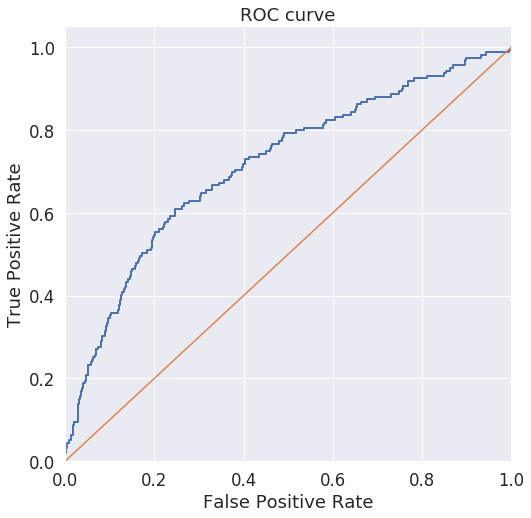

In [40]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 8))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()